In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import cv2
import pandas as pd

import os

from tqdm.notebook import tqdm, tnrange
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


# Deep learning

C'est dans ce notebook que le dernier modèle que la voiture possède a été calculé

Il se veut complet et modulable afin de pouvoir servir de base à la construction d'un autre réseau de neurones. Cela va du chargement des données à la validation du modèle.

Cf partie 6, section 3 du rapport

__/!\ /!\ /!\ Attention à ne pas écraser les poids précédant /!\ /!\ /!\__

### Segmentation du code

 1. Définition des constantes
 2. Création de la chaine de traitement
     * Crop
     * Normalize
     * DataFormatting
     * \+ récupération des labels
 3. Chargement des données
 4. \+ Visualisation de l'histogramme d'une photo
 5. Definition du modèle
     * et d'un plus petit
 6. Vérification des inputs et outputs du modèle
 7. Entrainement du modèle
 8. Affichage de l'évolution de la "loss function"
 9. Visualisation des performances du modèle
 10. Enregistrement des poids et test du fichier

## Définition des constantes

In [2]:
DATASET_PATH = "../data/datasetv3/"

# Création de la chaine de traitement

In [3]:
class Normalize():
    """
    Normalized the image with mean of 0 and std of 1
    """
    def __call__(self, sample):
        """
        Apply the transformation
        
        @param image: a grayscale OpenCV image
        @return: a Numpy array normalized image with dimension of (69, 223, 1)
        """
        norm_img = np.zeros(sample.shape)
        norm_img = cv2.normalize(sample, norm_img, 0, 1, cv2.NORM_MINMAX)
        norm_img = norm_img.reshape(69, 223, -1)
        return norm_img
    
class Crop:
    """
    Remove pixels on the top and the right
    Some right pixels are bugged...
    """
    def __call__(self, sample):
        """
        Apply the transformation

        @param image: a OpenCV image
        @return: the cropped image
        """
        width = sample.shape[1]
        return sample[45:, :width-5]
    
class DataFormatting:
    """
    Chnage data type of a Numpy array
    """
    def __call__(self, sample):
        """
        Apply the transformation

        @param sample: a Numpy image
        @return: the Numpy float32 image
        """
        image = sample.astype(np.float32)
        return image
    
def get_labels(name):    
    """
    Dataset labels are contained in the name of the files.
    
    bhz_frame12_0.079_0.982.png
    -> direction: 0.079
    -> speed: 0,964
    
    @param name: the filename of the image 
    @return direction: the direction value (float between -1 & 1)
    @return speed: the speed value (float between -1 & 1)
    """
    labels = name.split("_")
    
    direction = float(labels[2])
    if direction < -1:
        direction = -1
    elif direction > 1:
        direction = 1
    
    speed =  float(labels[3][:-4])
    speed *= 2
    speed -= 1
    if speed < -1:
        speed = -1
    elif speed > 1:
        speed = 1
    
    return direction, speed

# Chargement des données

In [4]:
image_name_list = np.array([
            name for name in os.listdir(DATASET_PATH)
                if os.path.isfile(os.path.join(DATASET_PATH, name)) and ".png" in name
        ])

transformations = [
    Crop(),
    Normalize(),
    DataFormatting(),
]

X = []
y = []

# load images and their labels in Numpy arrays
for name in tqdm(image_name_list):
    img_path = os.path.join(DATASET_PATH, name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # add the channel axis
    image = image.reshape(114, 228, -1)

    labels = get_labels(name)

    for transformation in transformations:
        image = transformation(image)

    X.append(image)
    y.append(labels)
    
    """
    image = cv2.flip(image, 1)
    image = image.reshape(69, 223, -1)
    labels = -labels[0], labels[1]
    X.append(image)
    y.append(labels)
    """
    
X = np.array(X)
y = np.array(y)

# Handmade shuffle of X and y
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]

print("Lenght of the whole dataset :", len(X))


# Handmade train test split
size_train = 0.8
idx_lim = int(size_train*len(X))

train_dataset = X[:idx_lim], y[:idx_lim]
test_dataset = X[idx_lim:], y[idx_lim:]

del X
del y

print("Number of labels :", len(train_dataset))
print("Lenght of the trainning dataset :", len(train_dataset[0]))
print("Lenght of the test dataset :", len(test_dataset[0]))

  0%|          | 0/18829 [00:00<?, ?it/s]

Lenght of the whole dataset : 18829
Number of labels : 2
Lenght of the trainning dataset : 15063
Lenght of the test dataset : 3766


## Visualisation de l'histogramme d'une photo

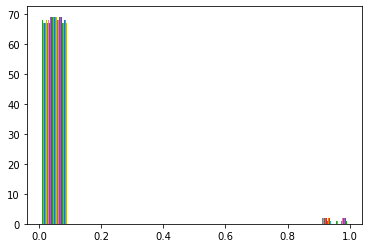

In [5]:
image = train_dataset[0][0].reshape(69, 223)
plt.figure()
plt.hist(image)
plt.show()

# Definition du modèle

Les 2 modèles sont composés de petites couches de convolution suivies d'un réseau dense. Il y a 2 valeurs en sortie, vitesse et angle de rotation.

In [6]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        
        layers.Dense(50, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(2, activation=None),
    ])

    optimizer = tf.keras.optimizers.Adam(0.002)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model

## et d'un plus petit

In [7]:
def build_model_small():
    model = keras.Sequential([
        layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        
        layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        
        layers.Flatten(),
        
        layers.Dense(50, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Dense(2, activation=None),
    ])

    optimizer = tf.keras.optimizers.Adam(0.002)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    
    print("Warning! It is the small model that is defined\n"*3)
    
    return model

# Vérification des inputs et outputs du modèle

In [8]:
model = build_model()
model.build((10, 69, 223, 1))
model.summary()

example_batch = test_dataset[0][:10]
example_result = model.predict(example_batch)
example_result

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  84        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
____

array([[ 0.01293147, -0.05989755],
       [ 0.22002943, -0.24172246],
       [ 0.06145897,  0.03059793],
       [ 0.05954167, -0.00850781],
       [ 0.06643577,  0.02567903],
       [ 0.10886352, -0.10066431],
       [ 0.12313315, -0.03337312],
       [ 0.08515117, -0.04590635],
       [ 0.08751025,  0.03168735],
       [ 0.02891751, -0.04597643]], dtype=float32)

# Entrainement du modèle

In [10]:
model = build_model()

EPOCHS = 20
epoch_evol = tqdm(total=EPOCHS, desc="Epochs")

# Display loss every 3 epochs
class PrintDot(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs):
        epoch_evol.update()
        if epoch % 3 == 2:
            print(f"MSE: {logs['loss']} - Validation MSE: {logs['val_mean_squared_error']}")

history = model.fit(
    train_dataset[0], train_dataset[1],
    epochs=EPOCHS,
    validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

MSE: 0.08503375830986688 - Validation MSE: 0.08818241208791733
MSE: 0.06115677554825035 - Validation MSE: 0.07901923358440399
MSE: 0.04979606420698255 - Validation MSE: 0.07437610626220703
MSE: 0.041956270494772685 - Validation MSE: 0.07218709588050842
MSE: 0.036456935507133297 - Validation MSE: 0.0720866397023201
MSE: 0.03231209688197775 - Validation MSE: 0.07426981627941132


# Affichage de l'évolution de la "loss function"

<AxesSubplot:>

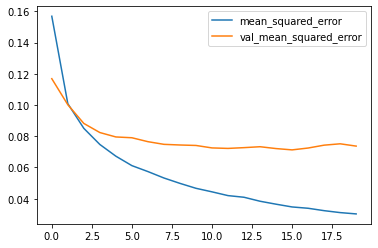

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

hist[['mean_squared_error', 'val_mean_squared_error']].plot()

# Visualisation des performances du modèle

Si tous les points des graphiques sont sur la ligne rouge, alors le modèle prédit exactement la vérité terrain.

(3766, 2)


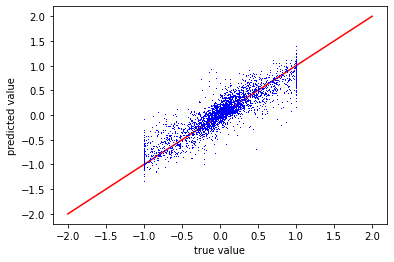

(3766, 2)


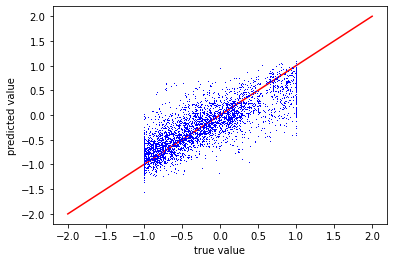

In [12]:
test_predictions = model.predict(test_dataset[0])
print(test_predictions.shape)

test_acc_count = 0
loss_sum = 0

plt.figure()
plt.plot([-2, 2], [-2, 2], color="red")
plt.plot(test_dataset[1][:, 0], test_predictions[:, 0], ',', color="blue")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.show()

plt.figure()
plt.plot([-2, 2], [-2, 2], color="red")
plt.plot(test_dataset[1][:, 1], test_predictions[:, 1], ',', color="blue")
plt.xlabel("true value")
plt.ylabel("predicted value")

print(test_dataset[1].shape)

plt.show()

# Enregistrement des poids et test du fichier

In [13]:
model.save_weights('../data/weights/weights_tf_last.h5')

In [14]:
# Recreate same architecture
test_model = keras.Sequential([
    layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(3, (3, 3), padding="valid", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(50, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(2, activation=None),
])

test_model.build((1, 69, 223, 1))

# load weights
test_model.load_weights('../data/weights/weights_tf_last.h5')

# and test with a frame
prediction = test_model.predict(test_dataset[0])

print("input shape:", test_dataset[0].shape)
print()
print("prediction:", prediction)
print("prediction shape:", prediction.shape)

input shape: (3766, 69, 223, 1)

prediction: [[ 0.05449308 -0.56065977]
 [-0.03591274 -0.57370234]
 [-0.12544139  0.05359633]
 ...
 [-0.1121867   0.1499382 ]
 [ 0.1086064  -0.26476407]
 [ 0.08843155  0.12935296]]
prediction shape: (3766, 2)
